In [339]:
import numpy as np

import cvxpy as cp
import matplotlib.pyplot as plt
import opt
import robustARMA_opt

In [340]:
def error_metrics(Y_hat, Y_test, H=None, H_gt=None, print_results=True):
    # Normalized error
    if Y_test.ndim == 2:
        norm_y = (Y_test**2).sum(1)#np.sqrt((Y_test**2).sum(1))
        err_y = np.mean(((Y_test - Y_hat)**2).sum(1) / norm_y)
    else:
        norm_y = (Y_test**2).sum((1,2))#np.sqrt((Y_test**2).sum(1))
        err_y = np.mean(((Y_test - Y_hat)**2).sum((1,2)) / norm_y)
    
    if print_results:
        print(f"Error in signal y: {err_y}")

    if H is not None and H_gt is not None:
        # Error wrt ground truth filter
        if H.ndim == 3: # Several filters
            norm_H = (H_gt**2).sum((1,2))
            err_H = np.mean(((H - H_gt)**2).sum((1,2)) / norm_H)
        else:
            norm_H = (H_gt**2).sum()
            err_H = ((H - H_gt)**2).sum() / norm_H

        if print_results:
            print(f"Error in filter: {err_H}")
        return err_y, err_H

    return err_y

In [341]:
def plot_filters(Hs):
    if Hs.ndim == 3:
        n_filt = Hs.shape[0]
    else:
        n_filt = 1
    f, ax = plt.subplots(1, n_filt, figsize=(12,8))

    if n_filt > 1:
        for i in range(n_filt):    
            ax[i].imshow(Hs[i,:,:])
    else:
        ax.imshow(Hs)

# Reading the data

In [342]:
#data = np.load('data_temp/temperatures2003_mod_knn8_N40.npz')
data = np.load('data_temp/temperatures2018_knn8_N28.npz') # 54 or 28 for only valid values, 36 for invalid values as well

In [343]:
A = data['A_bin']
temp_info = data['temps'] # data['X']

norm_data = False
if norm_data:
    temp_info -= np.mean(temp_info, 1)[:,None]
    temp_info /= np.std(temp_info, 1)[:,None]

diff = False
if diff:
    temp_info = np.diff(temp_info, axis=1) / temp_info[:,:1]

Y = temp_info[:,1:]
X = temp_info[:,:-1]
N, N_dates = X.shape

In [344]:
train_test_split = 0.5

random_train_test = False
if random_train_test:
    idxs = np.random.permutation(N_dates)
else:
    idxs = np.arange(N_dates)

idxs_train = idxs[:int(train_test_split*N_dates)]
idxs_test = idxs[int(train_test_split*N_dates):]

X_train = X[:,idxs_train]
Y_train = Y[:,idxs_train]
X_test = X[:,idxs_test]
Y_test = Y[:,idxs_test]
X_train.shape, Y_train.shape, N_dates

((28, 181), (28, 181), 363)

# Models

In [345]:
models = []
errs_y = []
errs_H = []

In [346]:
# Ground truth obtained using Least squares over all samples
H = cp.Variable((N,N))
obj = cp.sum_squares(Y_test - H @ X_test)
prob = cp.Problem(cp.Minimize(obj))
prob.solve()
H_gt = H.value

In [347]:
y_ls_perf = H_gt @ X_test
err_ls_per, err_H_ls_per = error_metrics(y_ls_perf, Y_test, H_gt, H_gt)
models.append("LS-Perfect (LB)"); errs_y.append(err_ls_per)

Error in signal y: 0.6313242740403059
Error in filter: 0.0


In [ ]:
plot_filters(H_gt)

## Toy models for comparison

In [348]:
Y_random = Y_test.std(1)[:,None] * np.random.randn(*Y_test.shape) + Y_test.mean(1)[:,None]
err_random = error_metrics(Y_random, Y_test)
models.append("Random Return"); errs_y.append(err_random)

Error in signal y: 2.010366691822356


In [349]:
Y_zeros = np.zeros(Y_test.shape)
err_zeros = error_metrics(Y_zeros, Y_test)
#models.append("Zero Return"); errs_y.append(err_zeros)

Error in signal y: 1.0


In [350]:
# Identity - copying the temperature from the previous day
H_eye = np.eye(N)
Y_eye = H_eye @ X_test
err_eye = error_metrics(Y_eye, Y_test)
models.append("Copy Prev Day"); errs_y.append(err_eye)

Error in signal y: 2.043301192416329


## Least squares

In [351]:
# Least squares
H = cp.Variable((N,N))
obj = cp.sum_squares(Y_train - H @ X_train)
prob = cp.Problem(cp.Minimize(obj))
prob.solve()
H_ls = H.value

In [352]:
Y_hat_ls = H_ls @ X_test
err_y_ls, err_H_ls = error_metrics(Y_hat_ls, Y_test, H_ls, H_gt)
models.append("Least Squares"); errs_y.append(err_y_ls); errs_H.append(err_H_ls)

Error in signal y: 1.3520567613264143
Error in filter: 3.674564893805842


In [ ]:
plot_filters(H_ls)

In [353]:
# Least squares postulating it is a graph filter
K = 5
Spow = np.array([np.linalg.matrix_power(A, k) for k in range(K)])
h = cp.Variable(K)
obj = cp.sum_squares(Y_train - cp.sum([h[k] * Spow[k,:,:] for k in range(K)]) @ X_train)
prob = cp.Problem(cp.Minimize(obj))
prob.solve()
h = h.value
H_ls_gf = np.sum([h[k] * Spow[k,:,:] for k in range(K)], 0)

In [354]:
Y_hat_ls_gf = H_ls_gf @ X_test
err_y_ls_gf, err_H_ls_gf = error_metrics(Y_hat_ls_gf, Y_test, H_ls_gf, H_gt)
models.append("Least Squares-GF"); errs_y.append(err_y_ls_gf); errs_H.append(err_H_ls_gf)

Error in signal y: 1.0050753373999577
Error in filter: 0.959216669830932


In [ ]:
plot_filters(H_ls_gf)

## Iterative (robust) algorithms

In [355]:
args = [0.4, 0.008, 0.0005, 3.]
args_no_st = [0.03, 0.005, 0., 3.5]
args_rew = [0.2, 0.1, 0.001, 0.0001, 1.1]
args_rew_no_st = [0.1, 0.08, 0., 5e-4, 1.]

In [356]:
X_norm = (X_train.T - np.mean(X_train.T, axis=0))/np.std(X_train.T, axis=0)

C = np.cov(X_norm.T)

In [357]:
iter, H_iter, S_iter = opt.estH_iter(X, Y, A, C, args)

In [ ]:
plot_filters(H_iter)

In [358]:
Y_hat_iter = H_iter @ X_test
err_iter, err_H_iter = error_metrics(Y_hat_iter, Y_test, H_iter, H_gt)
models.append("RGFI"); errs_y.append(err_iter); errs_H.append(err_H_iter)

Error in signal y: 0.9698005128408714
Error in filter: 0.9122284493357965


In [359]:
iter, H_iter_rew, S_iter_rew = opt.estH_iter_rew(X, Y, A, C, args_rew)

In [ ]:
plot_filters(H_iter_rew)

In [360]:
Y_hat_iter_rew = H_iter_rew @ X_test
err_iter_rew, err_H_iter_rew = error_metrics(Y_hat_iter_rew, Y_test, H_iter_rew, H_gt)
models.append("RGFI-REW"); errs_y.append(err_iter_rew); errs_H.append(err_H_iter_rew)

Error in signal y: 0.9731105112671244
Error in filter: 0.9176354092002349


In [361]:
((S_iter - A)**2).sum()

3.481874484997651e-10

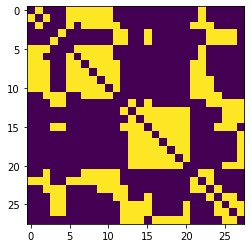

In [362]:
plt.imshow(S_iter)

# Multiple filters ARMA model

In [363]:
P = 2
Xs = np.array([temp_info[:,p:-P+p] for p in range(P)])
Y_mult = temp_info[:,P:]
N_dates_mult = Y_mult.shape[1]
Xs.shape, Y_mult.shape

((2, 28, 362), (28, 362))

In [364]:
idxs_mult = idxs.copy() # Using same split as in the previous cases, but needs to be adapted
for p in range(N_dates-P, N_dates): # Deleting invalid occurrences for this case
    idxs_mult = idxs_mult[idxs_mult != p]
idxs_train = idxs_mult[:int(train_test_split*N_dates_mult)]
idxs_test = idxs_mult[int(train_test_split*N_dates_mult):]
Xs_train = Xs[:,:,idxs_train]
Xs_test = Xs[:,:,idxs_test]
Y_mult_train = Y_mult[:,idxs_train]
Y_mult_test = Y_mult[:,idxs_test]

In [365]:
Hs = [cp.Variable((N, N)) for _ in range(P)]
obj = cp.sum_squares(Y_mult_test - cp.sum([Hs[p] @ Xs_test[p,:,:] for p in range(P)]))
prob = cp.Problem(cp.Minimize(obj))
prob.solve()
Hs_gt = np.array([Hs[p].value for p in range(P)])

In [366]:
Y_hat_perf = np.sum(Hs_gt @ Xs_test, 0)
err_mult_per = error_metrics(Y_hat_perf, Y_mult_test)
models.append("VARMA-LS-Perfect"); errs_y.append(err_mult_per)

Error in signal y: 0.4785316615665908


In [ ]:
plot_filters(Hs_gt)

## Least squares

In [367]:
Hs = [cp.Variable((N, N)) for _ in range(P)]
obj = cp.sum_squares(Y_mult_train - cp.sum([Hs[p] @ Xs_train[p,:,:] for p in range(P)]))
prob = cp.Problem(cp.Minimize(obj))
prob.solve()
Hs_ls = np.array([Hs[p].value for p in range(P)])

In [368]:
Y_hat_mult_ls = np.sum(Hs_ls @ Xs_test, 0)
err_mult_ls, err_H_mult_ls = error_metrics(Y_hat_mult_ls, Y_mult_test, Hs_ls, Hs_gt)
models.append("VARMA-LS"); errs_y.append(err_mult_ls); errs_H.append(err_H_mult_ls)

Error in signal y: 1.694834784873129
Error in filter: 3.023338953871269


In [ ]:
plot_filters(Hs_ls)

In [369]:
# Least squares postulating it is a graph filter
K = 5
hs = [cp.Variable(K) for _ in range(P)]
Hs = [cp.sum([hs[p][k] * Spow[k,:,:] for k in range(K)]) for p in range(P)]
obj = cp.sum_squares(Y_mult_train - cp.sum([Hs[p] @ Xs_train[p,:,:] for p in range(P)]))
prob = cp.Problem(cp.Minimize(obj))
prob.solve()
hs_ls = np.array([hs[p].value for p in range(P)])
H_mult_ls_gf = np.array([np.sum([hs_ls[p,k] * Spow[k,:,:] for k in range(5)], 0) for p in range(P)])

In [370]:
Y_hat_mult_ls_gf = np.sum(H_mult_ls_gf @ Xs_test, 0)
err_y_mult_ls_gf, err_H_mult_ls_gf = error_metrics(Y_hat_mult_ls_gf, Y_mult_test, H_mult_ls_gf, Hs_gt)
models.append("VARMA-LS-GF"); errs_y.append(err_y_mult_ls_gf); errs_H.append(err_H_mult_ls_gf)

Error in signal y: 0.9920420331404378
Error in filter: 0.9765760023711101


In [ ]:
plot_filters(Hs_ls_gf)

## Iterative (robust) algorithms

In [371]:
from robustARMA_opt import estHs_iter, estHs_iter_rew

In [372]:
args = [0.2, 1e-3, 0.02, 1.6]
args_no_st = [0.4, 1e-3, 0., 1.5]
args_rew = [0.07, 1e-3, 0.1, 5e-4, 3.]
args_rew_no_st = [0.02, 1e-4, 0., 5e-4, 2.]

In [373]:
iter, Hs_iter, Ss_iter = estHs_iter(Xs_train, Y_mult_train, A, C, args)

In [ ]:
plot_filters(Hs_iter)

In [374]:
Y_hat_mult_iter = np.sum(Hs_iter @ Xs_test, 0)
err_mult_iter, err_Hs_mult_iter = error_metrics(Y_hat_mult_iter, Y_mult_test, Hs_iter, Hs_gt)
models.append("VARMA-RGFI"); errs_y.append(err_mult_iter); errs_H.append(err_Hs_mult_iter)

Error in signal y: 1.0372015508969674
Error in filter: 0.9887339212929308


In [375]:
iter, Hs_iter_rew, Ss_iter_rew = estHs_iter_rew(Xs_train, Y_mult_train, A, C, args_rew)

In [ ]:
plot_filters(Hs_iter_rew)

In [376]:
Y_hat_mult_iter_rew = np.sum(Hs_iter_rew @ Xs_test, 0)
err_mult_iter_rew, err_Hs_mult_iter_rew = error_metrics(Y_hat_mult_iter_rew, Y_mult_test, Hs_iter_rew, Hs_gt)
models.append("VARMA-RGFI-REW"); errs_y.append(err_mult_iter_rew); errs_H.append(err_Hs_mult_iter_rew)

Error in signal y: 1.0141414486062241
Error in filter: 0.98632975973162


# Representation

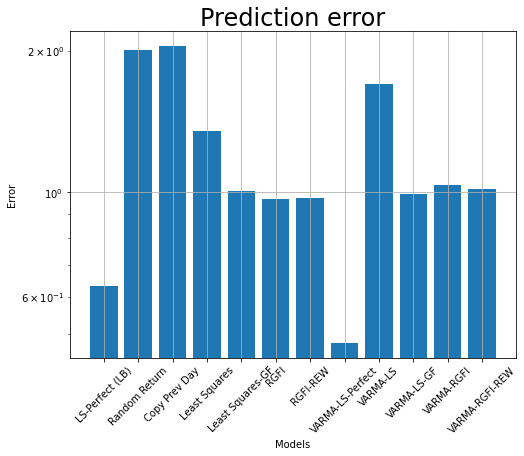

In [377]:
x_ax = np.arange(len(models))
plt.figure(figsize=(8,6))
plt.bar(x_ax, errs_y, log=True)
plt.xticks(x_ax, models, rotation=45)
plt.title("Prediction error", fontsize=24)
plt.xlabel("Models")
plt.ylabel("Error")
plt.grid()
#plt.ylim(0., 0.1)

# Multiple filters for multiple data

In [271]:
X1 = data['temps']
X2 = data['precs']
X3 = data['windsps']
X4 = data['press']
comp_data = np.array([
    X1,
    X2,
    X3,
#    X4
])
n_feat = comp_data.shape[0]

Ys = comp_data[:,:,1:].copy()
Xs = comp_data[:,:,:-1].copy()
Xs.shape, Ys.shape

((3, 28, 364), (3, 28, 364))

In [272]:
train_test_split = 0.6#1/6
N_dates = Xs.shape[2]

random_train_test = False
if random_train_test:
    idxs = np.random.permutation(N_dates)
else:
    idxs = np.arange(N_dates)

idxs_train = idxs[:int(train_test_split*N_dates)]
idxs_test = idxs[int(train_test_split*N_dates):]

Xs_train = Xs[:,:,idxs_train]
Ys_train = Ys[:,:,idxs_train]
Xs_test = Xs[:,:,idxs_test]
Ys_test = Ys[:,:,idxs_test]
Xs_train.shape, Ys_train.shape, Xs_test.shape, N_dates

((3, 28, 218), (3, 28, 218), (3, 28, 146), 364)

In [273]:
Hs_gt = []
for i in range(n_feat):
    H = cp.Variable((N,N))
    obj = cp.sum_squares(Ys_test[i,:,:] - H @ Xs_test[i,:,:])
    prob = cp.Problem(cp.Minimize(obj))
    prob.solve()
    Hs_gt.append(H.value)
Hs_gt = np.array(Hs_gt)

In [274]:
Ys_hat_gt = Hs_gt @ Xs_test
err_y_gt, err_H_gt = error_metrics(Ys_hat_gt, Ys_test, Hs_gt, Hs_gt)
#models.append("Least Squares"); errs_y.append(err_y_ls); errs_H.append(err_H_ls)
err_y_gt, err_H_gt

Error in signal y: 0.20294787586602803
Error in filter: 0.0


(0.20294787586602803, 0.0)

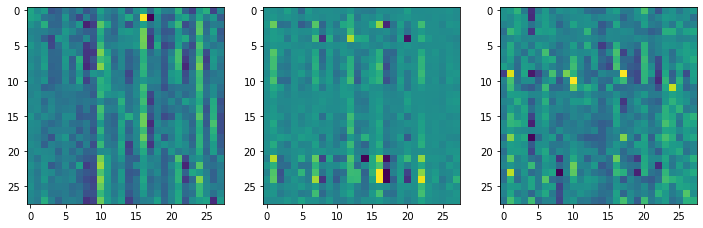

In [275]:
plot_filters(Hs_gt)

## Least squares

In [276]:
Hs_ls = []
for i in range(n_feat):
    H = cp.Variable((N,N))
    obj = cp.sum_squares(Ys_train[i,:,:] - H @ Xs_train[i,:,:])
    prob = cp.Problem(cp.Minimize(obj))
    prob.solve()
    Hs_ls.append(H.value)
Hs_ls = np.array(Hs_ls)

In [277]:
Xs[1,:,:].max()

2.59

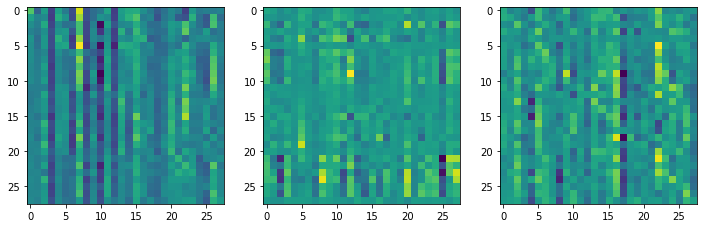

In [278]:
plot_filters(Hs_ls)

In [279]:
Ys_hat_ls = Hs_ls @ Xs_test
norm_y = (Ys_test**2).sum((1,2))#np.sqrt((Y_test**2).sum(1))
err_y = ((Ys_test - Ys_hat_ls)**2).sum((1,2)) / norm_y
err_y, norm_y

(array([0.00822395, 1.09202809, 0.21333509]),
 array([1.13797341e+07, 1.80623200e+02, 1.38180010e+05]))

In [280]:
Ys_hat_ls = Hs_ls @ Xs_test
err_y_ls, err_H_ls = error_metrics(Ys_hat_ls, Ys_test, Hs_ls, Hs_gt)
#models.append("Least Squares"); errs_y.append(err_y_ls); errs_H.append(err_H_ls)
err_y_ls, err_H_ls

Error in signal y: 0.43786237594005245
Error in filter: 1.6242737099390174


(0.43786237594005245, 1.6242737099390174)

In [281]:
# Least squares postulating it is a graph filter
K = 5
Spow = np.array([np.linalg.matrix_power(A, k) for k in range(K)])
Hs_ls_gf = []
for i in range(n_feat):
    h = cp.Variable(K)
    obj = cp.sum_squares(Ys_train[i,:,:] - cp.sum([h[k] * Spow[k,:,:] for k in range(K)]) @ Xs_train[i,:,:])
    prob = cp.Problem(cp.Minimize(obj))
    prob.solve()
    h = h.value
    Hs_ls_gf.append(np.sum([h[k] * Spow[k,:,:] for k in range(K)], 0))
Hs_ls_gf = np.array(Hs_ls_gf)

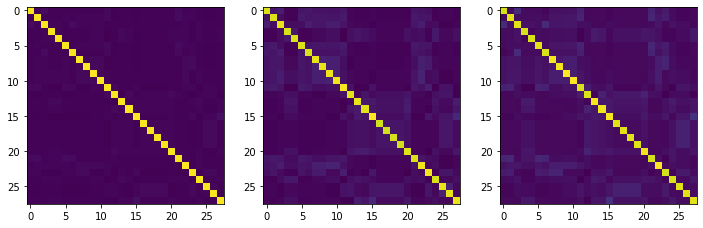

In [282]:
plot_filters(Hs_ls_gf)

In [283]:
Ys_hat_ls_gf = Hs_ls_gf @ Xs_test
err_y_ls, err_H_ls = error_metrics(Ys_hat_ls_gf, Ys_test, Hs_ls, Hs_gt)
#models.append("LS-GF"); errs_y.append(err_y_ls); errs_H.append(err_H_ls)
err_y_ls_gf, err_H_ls_gf

Error in signal y: 0.3497348074046007
Error in filter: 1.6242737099390174


(1.0050753373999577, 0.959216669830932)

## Iterative (robust) algorithms

In [284]:
import sev_filters_opt

In [285]:
args = [0.2, 1e-3, 0.02, 1.6]
args_no_st = [0.4, 1e-3, 0., 1.5]
args_rew = [0.07, 1e-3, 0.1, 5e-4, 3.]
args_rew_no_st = [0.02, 1e-4, 0., 5e-4, 2.]

In [286]:
meanX = comp_data.mean(2)
stdX = comp_data.std(2)
Cs = np.zeros((n_feat, N, N))
for i in range(n_feat):
    X_norm = (comp_data[i,:,:].T - meanX[i,:]) / stdX[i,:]

    X_norm = np.where(np.isnan(X_norm), comp_data[i,:,:].T, X_norm)
    
    Cs[i,:,:] = np.cov(X_norm.T)

In [287]:
iter, Hs_iter, Ss_iter = sev_filters_opt.estHs_iter(Xs_train, Ys_train, A, Cs, args)

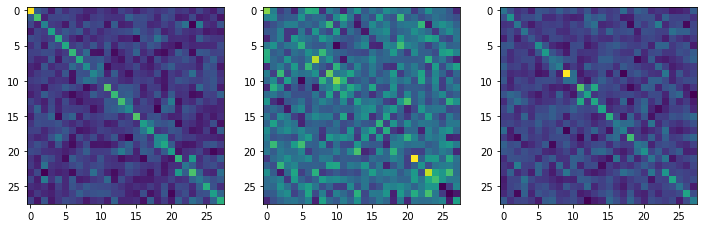

In [288]:
plot_filters(Hs_iter)

In [289]:
Ys_hat_iter = Hs_iter @ Xs_test
norm_y = (Ys_test**2).sum((1,2))#np.sqrt((Y_test**2).sum(1))
err_y = ((Ys_test - Ys_hat_iter)**2).sum((1,2)) / norm_y
err_y, norm_y

(array([0.00584054, 0.80521577, 0.20364206]),
 array([1.13797341e+07, 1.80623200e+02, 1.38180010e+05]))

In [290]:
Ys_hat_iter = Hs_iter @ Xs_test
err_ys_iter, err_Hs_iter = error_metrics(Ys_hat_iter, Ys_test, Hs_iter, Hs_gt)
#models.append("VARMA-RGFI"); errs_y.append(err_mult_iter); errs_H.append(err_Hs_mult_iter)
err_ys_iter, err_Hs_iter

Error in signal y: 0.3382327901479922
Error in filter: 0.9846433714690033


(0.3382327901479922, 0.9846433714690033)

# Subset

In [291]:
n_hidden = 20#int(N/4)
mask_hidden = np.zeros(N, dtype=bool)
mask_hidden[np.random.choice(N, n_hidden, replace=False)] = True

In [292]:
X_all = temp_info.copy()
X_hid = temp_info.copy()[mask_hidden,:]
X_obs = temp_info.copy()[~mask_hidden,:]
X_zeroed = temp_info.copy()
X_zeroed[mask_hidden,:] = 0.
N_el = X_all.shape[1]
X_hid.shape, X_obs.shape, X_zeroed.shape

((20, 364), (8, 364), (28, 364))

## Error on all nodes for optimization (division train-test)

In [293]:
train_test_split = 1/6

random_train_test = False
if random_train_test:
    idxs = np.random.permutation(N_el)
else:
    idxs = np.arange(N_el)

idxs_train = idxs[:int(train_test_split*N_el)]
idxs_test = idxs[int(train_test_split*N_el):]

In [294]:
X_all_train = X_all[:,idxs_train]
X_all_test = X_all[:,idxs_test]

X_hid_train = X_hid[:,idxs_train]
X_hid_test = X_hid[:,idxs_test]

X_obs_train = X_obs[:,idxs_train]
X_obs_test = X_obs[:,idxs_test]

X_zeroed_train = X_zeroed[:,idxs_train]
X_zeroed_test = X_zeroed[:,idxs_test]

In [295]:
models = []
errs_hid = []
errs_all = []

### Least squares

In [296]:
# Least squares
H = cp.Variable((N,N))
obj = cp.sum_squares(X_all_train - H @ X_zeroed_train)
#constraints = [cp.diag(H) == 0]
prob = cp.Problem(cp.Minimize(obj))#, constraints)
prob.solve()
H_hid = H.value

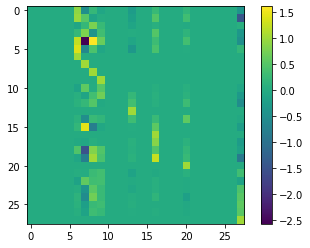

In [297]:
plt.imshow(H_hid)
plt.colorbar()

In [298]:
X_hat = (H_hid @ X_zeroed_test)[mask_hidden,:]

# Normalized error on hidden nodes
norm_y_hid = (X_hid_test**2).sum(1)#np.sqrt((Y_test**2).sum(1))
err_y_hid = np.mean(((X_hid_test - X_hat)**2).sum(1) / norm_y_hid)
models.append("Least Squares"); errs_hid.append(err_y_hid)
err_y_hid

0.44618036267466843

In [299]:
X_hat = H_hid @ X_zeroed_test

# Normalized error on all nodes
norm_y_all = (X_all_test**2).sum(1)#np.sqrt((Y_test**2).sum(1))
err_y_all = np.mean(((X_all_test - X_hat)**2).sum(1) / norm_y_all)
errs_all.append(err_y_all)
err_y_all

0.3187002590533346

In [300]:
# Least squares postulating it is a graph filter
K = 5
Spow = np.array([np.linalg.matrix_power(A, k) for k in range(K)])
h = cp.Variable(K)
H = cp.sum([h[k] * Spow[k,:,:] for k in range(K)])
obj = cp.sum_squares(X_all_train - H @ X_zeroed_train)
prob = cp.Problem(cp.Minimize(obj))
prob.solve()
h = h.value
H_hid_gf = np.sum([h[k] * Spow[k,:,:] for k in range(K)], 0)

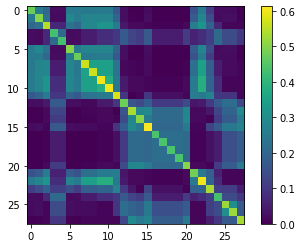

In [301]:
plt.imshow(H_hid_gf)
plt.colorbar()

In [302]:
X_hat = (H_hid_gf @ X_zeroed_test)[mask_hidden,:]

# Normalized error on hidden nodes
norm_y_hid = (X_hid_test**2).sum(1)#np.sqrt((Y_test**2).sum(1))
err_y_hid = np.mean(((X_hid_test - X_hat)**2).sum(1) / norm_y_hid)
#models.append("LS-GF"); errs_hid.append(err_y_hid)
err_y_hid

0.5678635547781822

In [303]:
X_hat = H_hid_gf @ X_zeroed_test

# Normalized error on all nodes
norm_y_all = (X_all_test**2).sum(1)#np.sqrt((Y_test**2).sum(1))
err_y_all = np.mean(((X_all_test - X_hat)**2).sum(1) / norm_y_all)
#errs_all.append(err_y_all)
err_y_all

0.5252016126090863

### Iterative (robust) algorithms

In [304]:
iter, H_hid_iter, S_hid_iter = opt.estH_iter(X_zeroed_train, X_all_train, A, C, args)

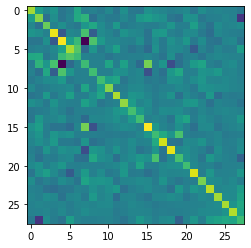

In [305]:
plt.imshow(H_hid_iter)

In [306]:
X_hat = (H_hid_iter @ X_zeroed_test)[mask_hidden,:]

# Normalized error on hidden nodes
norm_y_hid = (X_hid_test**2).sum(1)#np.sqrt((Y_test**2).sum(1))
err_y_hid = np.mean(((X_hid_test - X_hat)**2).sum(1) / norm_y_hid)
models.append("RGFI-ITER"); errs_hid.append(err_y_hid)
err_y_hid

0.41486526255763945

In [307]:
X_hat = H_hid_iter @ X_zeroed_test

# Normalized error on all nodes
norm_y_all = (X_all_test**2).sum(1)#np.sqrt((Y_test**2).sum(1))
err_y_all = np.mean(((X_all_test - X_hat)**2).sum(1) / norm_y_all)
errs_all.append(err_y_all)
err_y_all

0.2977081550093294

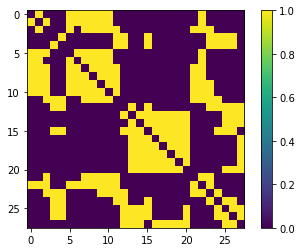

In [308]:
plt.imshow(A)
plt.colorbar()

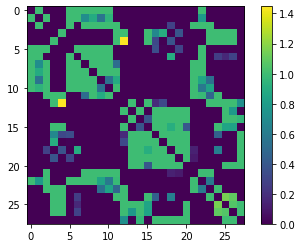

In [309]:
plt.imshow(S_hid_iter)
plt.colorbar()

In [310]:
iter, H_hid_iter_rew, S_hid_iter_rew = opt.estH_iter_rew(X_zeroed_train, X_all_train, A, C, args_rew)

In [311]:
X_hat = (H_hid_iter_rew @ X_zeroed_test)[mask_hidden,:]

# Normalized error on hidden nodes
norm_y_hid = (X_hid_test**2).sum(1)#np.sqrt((Y_test**2).sum(1))
err_y_hid = np.mean(((X_hid_test - X_hat)**2).sum(1) / norm_y_hid)
models.append("RGFI-ITER-REW"); errs_hid.append(err_y_hid)
err_y_hid

0.4100448430479598

In [312]:
X_hat = H_hid_iter_rew @ X_zeroed_test

# Normalized error on all nodes
norm_y_all = (X_all_test**2).sum(1)#np.sqrt((Y_test**2).sum(1))
err_y_all = np.mean(((X_all_test - X_hat)**2).sum(1) / norm_y_all)
errs_all.append(err_y_all)
err_y_all

0.29684930525417175

In [313]:
errs_hid, errs_all

([0.44618036267466843, 0.41486526255763945, 0.4100448430479598],
 [0.3187002590533346, 0.2977081550093294, 0.29684930525417175])

Text(0.5, 1.0, 'Error on all nodes')

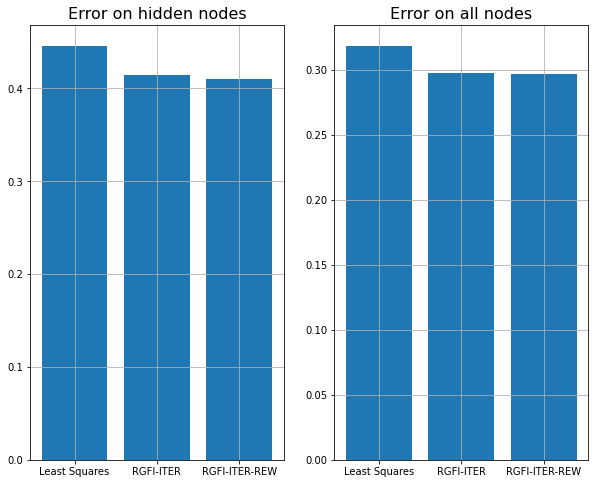

In [314]:
f, ax = plt.subplots(1,2, figsize=(10,8))
x_ax = np.arange(len(models))
for i, yseries in enumerate([errs_hid, errs_all]):
    ax[i].bar(x_ax, yseries)
    ax[i].set_xticks(x_ax)
    ax[i].set_xticklabels(models)
    ax[i].grid()
ax[0].set_title("Error on hidden nodes", fontsize=16)
ax[1].set_title("Error on all nodes", fontsize=16)
#ax[0].set_ylim(0.0115,0.012)

## Error only on hidden nodes for optimization

In [315]:
models = []
errs_hid = []
errs_all = []

### Least squares

In [316]:
# Optimizing error on all the nodes but data for hidden nodes is still 0
# Least squares
H = cp.Variable((N,N))
obj = cp.sum_squares(X_hid_train - (H @ X_zeroed_train)[mask_hidden,:])
#constraints = [cp.diag(H) == 0]
prob = cp.Problem(cp.Minimize(obj))#, constraints)
prob.solve()
H_hid = H.value

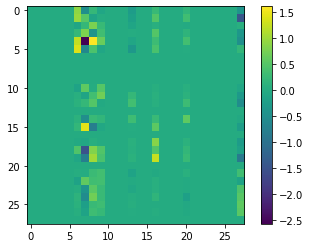

In [317]:
plt.imshow(H_hid)
plt.colorbar()

In [318]:
X_hat = (H_hid @ X_zeroed_test)[mask_hidden,:]

# Normalized error on hidden nodes
norm_y_hid = (X_hid_test**2).sum(1)
err_y_hid = np.mean(((X_hid_test - X_hat)**2).sum(1) / norm_y_hid)
models.append("Least Squares"); errs_hid.append(err_y_hid)
err_y_hid

0.44618036267466843

In [319]:
X_hat = H_hid @ X_zeroed_test

# Normalized error on all nodes
norm_y_all = (X_all_test**2).sum(1)#np.sqrt((Y_test**2).sum(1))
err_y_all = np.mean(((X_all_test - X_hat)**2).sum(1) / norm_y_all)
errs_all.append(err_y_all)
err_y_all

0.6044145447676202

### Iterative (robust) algorithms

In [320]:
import opt_subset

In [321]:
iter, H_hid_iter, S_hid_iter = opt_subset.estH_iter(X_zeroed_train, X_hid_train, A, C, mask_hidden, args)

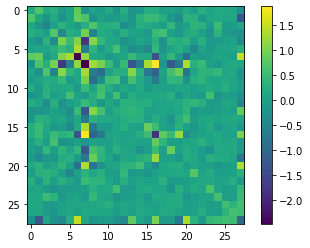

In [322]:
plt.imshow(H_hid_iter)
plt.colorbar()

In [323]:
X_hat = (H_hid_iter @ X_zeroed_test)[mask_hidden,:]

# Normalized error on hidden nodes
norm_y_hid = (X_hid_test**2).sum(1)#np.sqrt((Y_test**2).sum(1))
err_y_hid = np.mean(((X_hid_test - X_hat)**2).sum(1) / norm_y_hid)
models.append("RGFI-ITER"); errs_hid.append(err_y_hid)
err_y_hid

0.414667620015714

In [324]:
print(X_hat)
print(X_all_test)
print(mask_hidden)

[[ 1.10559411e-02 -4.06068864e-02 -1.96834880e-02 ...  1.01114669e-01
   6.69103435e-02 -2.27497861e-01]
 [ 1.74938309e-02 -4.50464353e-02  3.54648269e-02 ...  1.52779730e-01
   3.12483682e-01 -4.44480313e-01]
 [ 3.47322365e-02 -9.05968965e-02  1.52705240e-01 ...  1.45681677e-01
  -7.59994826e-02 -2.27675937e-01]
 ...
 [ 1.97316132e-04 -9.37549024e-02  1.29472731e-01 ...  2.01083500e-01
  -9.61350837e-02 -2.10566135e-01]
 [ 3.45201189e-03 -6.90029464e-02  7.85842545e-02 ...  1.49537467e-01
  -4.80662311e-02 -1.42487682e-01]
 [ 1.81201459e-03 -7.08206069e-02  8.90806231e-02 ...  1.53975952e-01
  -5.64589202e-02 -1.39307408e-01]]
[[ 0.04658385 -0.02484472  0.05590062 ...  0.09937888  0.1863354
  -0.23913043]
 [-0.20434783  0.05652174 -0.03043478 ...  0.36956522  0.18695652
  -0.4826087 ]
 [ 0.0119403  -0.10447761  0.11343284 ...  0.12238806  0.
  -0.31343284]
 ...
 [-0.03601108 -0.02770083  0.07479224 ...  0.26315789 -0.13850416
  -0.2132964 ]
 [-0.02185792 -0.04371585  0.05464481 ...  0

In [325]:
X_hat = H_hid_iter @ X_zeroed_test

# Normalized error on all nodes
norm_y_all = (X_all_test**2).sum(1)#np.sqrt((Y_test**2).sum(1))
err_y_all = np.mean(((X_all_test - X_hat)**2).sum(1) / norm_y_all)
errs_all.append(err_y_all)
err_y_all

4.355828002751646

Text(0.5, 1.0, 'Error on all nodes')

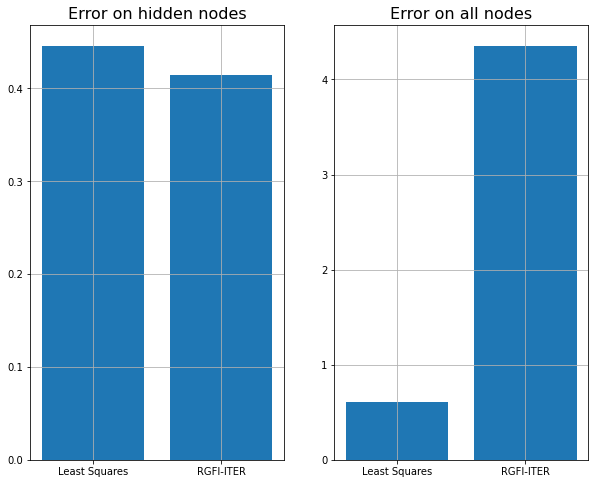

In [326]:
f, ax = plt.subplots(1,2, figsize=(10,8))
x_ax = np.arange(len(models))
for i, yseries in enumerate([errs_hid, errs_all]):
    ax[i].bar(x_ax, yseries)
    ax[i].set_xticks(x_ax)
    ax[i].set_xticklabels(models)
    ax[i].grid()
ax[0].set_title("Error on hidden nodes", fontsize=16)
ax[1].set_title("Error on all nodes", fontsize=16)
#ax[0].set_ylim(0.0115,0.012)

## Error only on observed nodes for optimization - no division train test

In [327]:
models = []
errs_hid = []
errs_all = []

### Least squares

In [328]:
# Optimizing error on all the nodes but data for hidden nodes is still 0
# Least squares
H = cp.Variable((N,N))
obj = cp.sum_squares(X_hid - (H @ X_zeroed)[mask_hidden,:])
#constraints = [cp.diag(H) == 0]
prob = cp.Problem(cp.Minimize(obj))#, constraints)
prob.solve()
H_hid = H.value

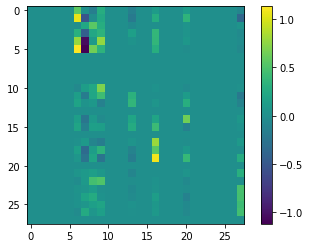

In [329]:
plt.imshow(H_hid)
plt.colorbar()

In [330]:
X_hat = (H_hid @ X_zeroed)[mask_hidden,:]

# Normalized error on hidden nodes
norm_y_hid = (X_hid**2).sum(1)
err_y_hid = np.mean(((X_hid - X_hat)**2).sum(1) / norm_y_hid)
models.append("Least Squares"); errs_hid.append(err_y_hid)
err_y_hid

0.3102683153384535

In [331]:
X_hat = H_hid @ X_zeroed

# Normalized error on all nodes
norm_y_all = (X_all**2).sum(1)#np.sqrt((Y_test**2).sum(1))
err_y_all = np.mean(((X_all - X_hat)**2).sum(1) / norm_y_all)
errs_all.append(err_y_all)
err_y_all

0.5073345109560382

### Iterative (robust) algorithms

In [332]:
import opt_subset

In [333]:
iter, H_hid_iter, S_hid_iter = opt_subset.estH_iter(X_zeroed, X_hid, A, C, mask_hidden, args)

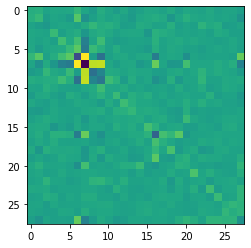

In [334]:
plt.imshow(H_hid_iter)

In [335]:
X_hat = (H_hid_iter @ X_zeroed)[mask_hidden,:]

# Normalized error on hidden nodes
norm_y_hid = (X_hid**2).sum(1)#np.sqrt((Y_test**2).sum(1))
err_y_hid = np.mean(((X_hid - X_hat)**2).sum(1) / norm_y_hid)
models.append("RGFI-ITER"); errs_hid.append(err_y_hid)
err_y_hid

0.31047235345157176

In [336]:
X_hat = H_hid_iter @ X_zeroed

# Normalized error on all nodes
norm_y_all = (X_all**2).sum(1)#np.sqrt((Y_test**2).sum(1))
err_y_all = np.mean(((X_all - X_hat)**2).sum(1) / norm_y_all)
errs_all.append(err_y_all)
err_y_all

2.467957132546488

Text(0.5, 1.0, 'Error on all nodes')

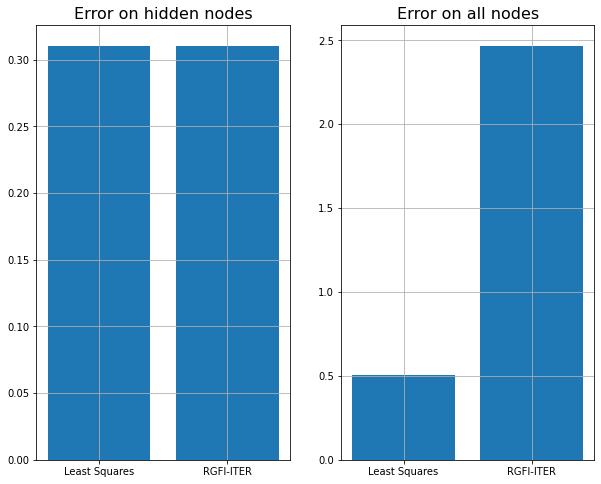

In [337]:
f, ax = plt.subplots(1,2, figsize=(10,8))
x_ax = np.arange(len(models))
for i, yseries in enumerate([errs_hid, errs_all]):
    ax[i].bar(x_ax, yseries)
    ax[i].set_xticks(x_ax)
    ax[i].set_xticklabels(models)
    ax[i].grid()
ax[0].set_title("Error on hidden nodes", fontsize=16)
ax[1].set_title("Error on all nodes", fontsize=16)
#ax[0].set_ylim(0.0115,0.012)